# **Notebook zur Evaluation - Trajektorien**
***

In [188]:
import csv
import numpy as np
from scipy.spatial.transform import Rotation as R
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import matplotlib.cm as cm
import plotly.graph_objects as go
import os
import re
import pandas as pd

***
### **Trajektorien CSVs laden**

In [189]:
hook_num = 1
v = 10
hook_model = 'A'
frame = '_work'
frame = ''
num_interp_points = 101

hole_width = 8
hole_height = 12

hook_width = 1.8
hook_height = 5.4

In [190]:
def load_csv_to_trajectory(filepath):
    """Lädt die CSV und stellt Trajektorie-Liste wieder her"""
    trajectory = []
    with open(filepath, mode='r', newline='') as file:
        reader = csv.reader(file)
        next(reader)  # Überspringe Kopfzeile

        for row in reader:
            numbers = list(map(float, row))
            trans = numbers[:3]
            rot = numbers[3:]
            trajectory.append((trans, rot))
    return trajectory

In [191]:
traj_optim_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_0' + str(frame) + '.csv'
traj_1_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_1' + str(frame) + '.csv'
traj_2_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_2' + str(frame) + '.csv'
traj_3_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_3' + str(frame) + '.csv'
traj_4_path = '/home/mo/Thesis/Evaluation/Trajektorientests/Modell' + hook_model + '/v_' + str(v) + '/' + str(hook_num) + '/trajectory_4' + str(frame) + '.csv'

In [192]:
trajectory_optim = load_csv_to_trajectory(traj_optim_path)
trajectory_1 = load_csv_to_trajectory(traj_1_path)
trajectory_2 = load_csv_to_trajectory(traj_2_path)
trajectory_3 = load_csv_to_trajectory(traj_3_path)
trajectory_4 = load_csv_to_trajectory(traj_4_path)

***
### **Interpolation der Trajektorie**

In [193]:
def interpolate_trajectory(traj, num_points):
    """
    Interpoliert eine Trajektorie auf `num_points` gleichmäßig verteilte Punkte.
    Nur die translatorischen Komponenten werden verwendet (3D Punkte).
    """
    positions = np.array([p[0] for p in traj])  # Nur Positionen
    rotations = np.array([p[1] for p in traj])  # Nur Rotationen

    # Abstände zwischen aufeinanderfolgenden Punkten
    deltas_trans = np.linalg.norm(np.diff(positions, axis=0), axis=1)
    cumulative_dist_trans = np.concatenate([[0], np.cumsum(deltas_trans)])
    target_distances_trans = np.linspace(0, cumulative_dist_trans[-1], num_points)

    interp_positions = []
    for dist in target_distances_trans:
        idx = np.searchsorted(cumulative_dist_trans, dist) - 1
        idx = np.clip(idx, 0, len(positions) - 2)
        t = (dist - cumulative_dist_trans[idx]) / (cumulative_dist_trans[idx + 1] - cumulative_dist_trans[idx])
        point = (1 - t) * positions[idx] + t * positions[idx + 1]
        interp_positions.append(point)

    # Rotationsteil
    if np.allclose(rotations, rotations[0]):  # wenn alle Rotationswerte gleich sind (Ansatz 2-4)
        interp_rotations = [rotations[0]] * num_points
    else:
        deltas_rot = np.linalg.norm(np.diff(rotations, axis=0), axis=1)
        cumulative_dist_rot = np.concatenate([[0], np.cumsum(deltas_rot)])
        target_distances_rot = np.linspace(0, cumulative_dist_rot[-1], num_points)

        interp_rotations = []
        for rot in target_distances_rot:
            idx = np.searchsorted(cumulative_dist_rot, rot) - 1
            idx = np.clip(idx, 0, len(rotations) - 2)
            denom = cumulative_dist_rot[idx + 1] - cumulative_dist_rot[idx]
            t = 0 if denom == 0 else (rot - cumulative_dist_rot[idx]) / denom
            point = (1 - t) * rotations[idx] + t * rotations[idx + 1]
            interp_rotations.append(point)
    return np.array(interp_positions), np.array(interp_rotations)

def compute_rectangle_corners(trajectory, width=8, height=12):
    rectangles = []

    half_w = width / 2
    half_h = height / 2

    # Rechteck immer in der XZ-Ebene
    local_corners = np.array([
        [-half_w, 0, -half_h],
        [ half_w, 0, -half_h],
        [ half_w, 0,  half_h],
        [-half_w, 0,  half_h]
    ])

    for pos, rpy in trajectory:
        rot = R.from_euler('xyz', rpy, degrees=True)
        rotated_corners = rot.apply(local_corners)
        translated_corners = rotated_corners + np.array(pos)
        rectangles.append(translated_corners.tolist())

    return rectangles

In [194]:
interp_positions_optim, interp_rotations_optim = interpolate_trajectory(trajectory_optim, num_interp_points)
trajectory_optim = list(zip(interp_positions_optim, interp_rotations_optim))
rectangles_optim = compute_rectangle_corners(trajectory_optim, width=hole_width, height=hole_height)
rectangles_optim_hooks = compute_rectangle_corners(trajectory_optim, width = hook_width, height = hook_height)

interp_positions_1, interp_rotations_1 = interpolate_trajectory(trajectory_1, num_interp_points)
trajectory_1 = list(zip(interp_positions_1, interp_rotations_1))
rectangles_1 = compute_rectangle_corners(trajectory_1, width=hole_width, height=hole_height)

interp_positions_2, interp_rotations_2 = interpolate_trajectory(trajectory_2, num_interp_points)
trajectory_2 = list(zip(interp_positions_2, interp_rotations_2))
rectangles_2 = compute_rectangle_corners(trajectory_2, width=hole_width, height=hole_height)

interp_positions_3, interp_rotations_3 = interpolate_trajectory(trajectory_3, num_interp_points)
trajectory_3 = list(zip(interp_positions_3, interp_rotations_3))
rectangles_3 = compute_rectangle_corners(trajectory_3, width=hole_width, height=hole_height)

interp_positions_4, interp_rotations_4 = interpolate_trajectory(trajectory_4, num_interp_points)
trajectory_4 = list(zip(interp_positions_4, interp_rotations_4))
rectangles_4 = compute_rectangle_corners(trajectory_4, width=hole_width, height=hole_height)

***
### **Berechnung der Abweichungen zwischen Trajektorie und Optimalwerten**

In [195]:
def absolute_traj_differences(traj_optim, traj):
    measurements = {}
    # Globale Diffs
    x_diffs, y_diffs, z_diffs = [], [], []
    roll_diffs, pitch_diffs, yaw_diffs = [], [], []
    euclidean_diffs = []

    # Lokale Diffs
    x_diffs_local, y_diffs_local, z_diffs_local = [], [], []

    if len(traj_optim) != len(traj):
        print("ERROR - Length of trajectories unequal!")
    else:
        for idx in range(len(traj_optim)):
            pos1, rpy1 = traj_optim[idx]
            pos2, rpy2 = traj[idx]

            pos1 = np.array(pos1)
            pos2 = np.array(pos2)
            rot1 = np.array(rpy1)
            rot2 = np.array(rpy2)

            pos_diff = np.round(pos2 - pos1, 2)
            rot_diff = np.round(rot2 - rot1, 2)

            # globale Differenzen
            euclidean_diffs.append(np.round(np.linalg.norm(pos_diff), 2))
            x_diffs.append(pos_diff[0])
            y_diffs.append(pos_diff[1])
            z_diffs.append(pos_diff[2])
            roll_diffs.append(rot_diff[0])
            pitch_diffs.append(rot_diff[1])
            yaw_diffs.append(rot_diff[2])

            # lokale Transformierung
            r = R.from_euler('xyz', rpy1, degrees=True)

            local_diff = np.round(r.inv().apply(pos_diff), 2)
            x_diffs_local.append(local_diff[0])
            y_diffs_local.append(local_diff[1])
            z_diffs_local.append(local_diff[2])

    # globale Einträge
    measurements['x_diffs'] = x_diffs
    measurements['y_diffs'] = y_diffs
    measurements['z_diffs'] = z_diffs
    measurements['roll_diffs'] = roll_diffs
    measurements['pitch_diffs'] = pitch_diffs
    measurements['yaw_diffs'] = yaw_diffs
    measurements['euclidean_diffs'] = euclidean_diffs

    measurements['x_min'] = np.round(np.min(x_diffs), 2)
    measurements['x_max'] = np.round(np.max(x_diffs), 2)
    measurements['y_min'] = np.round(np.min(y_diffs), 2)
    measurements['y_max'] = np.round(np.max(y_diffs), 2)
    measurements['z_min'] = np.round(np.min(z_diffs), 2)
    measurements['z_max'] = np.round(np.max(z_diffs), 2)

    measurements['x_diffs_mean'] = np.round(np.mean(x_diffs), 2)
    measurements['y_diffs_mean'] = np.round(np.mean(y_diffs), 2)
    measurements['z_diffs_mean'] = np.round(np.mean(z_diffs), 2)

    # lokale Einträge
    measurements['x_diffs_local'] = x_diffs_local
    measurements['y_diffs_local'] = y_diffs_local
    measurements['z_diffs_local'] = z_diffs_local

    measurements['x_min_local'] = np.round(np.min(x_diffs_local), 2)
    measurements['x_max_local'] = np.round(np.max(x_diffs_local), 2)
    measurements['y_min_local'] = np.round(np.min(y_diffs_local), 2)
    measurements['y_max_local'] = np.round(np.max(y_diffs_local), 2)
    measurements['z_min_local'] = np.round(np.min(z_diffs_local), 2)
    measurements['z_max_local'] = np.round(np.max(z_diffs_local), 2)

    measurements['x_diffs_mean_local'] = np.round(np.mean(x_diffs_local), 2)
    measurements['y_diffs_mean_local'] = np.round(np.mean(y_diffs_local), 2)
    measurements['z_diffs_mean_local'] = np.round(np.mean(z_diffs_local), 2)
    return measurements

In [196]:
traj1_measurements = absolute_traj_differences(traj_optim = trajectory_optim, traj = trajectory_1)
traj2_measurements = absolute_traj_differences(traj_optim = trajectory_optim, traj = trajectory_2)
traj3_measurements = absolute_traj_differences(traj_optim = trajectory_optim, traj = trajectory_3)
traj4_measurements = absolute_traj_differences(traj_optim = trajectory_optim, traj = trajectory_4)

In [197]:
def plot_position_differences(measurements, hook_num, trajectory_process=0):
    # Globale Werte
    x = measurements['x_diffs']
    y = measurements['y_diffs']
    z = measurements['z_diffs']
    x_diffs_mean = measurements['x_diffs_mean']
    y_diffs_mean = measurements['y_diffs_mean']
    z_diffs_mean = measurements['z_diffs_mean']

    # Lokale Werte
    x_loc = measurements['x_diffs_local']
    y_loc = measurements['y_diffs_local']
    z_loc = measurements['z_diffs_local']
    x_loc_mean = measurements['x_diffs_mean_local']
    y_loc_mean = measurements['y_diffs_mean_local']
    z_loc_mean = measurements['z_diffs_mean_local']

    n = len(x)
    t = list(range(n))

    fig, axs = plt.subplots(2, 1, figsize=(14, 10))
    fig.suptitle(f"Positionsdifferenzen für Haken {hook_num} - Trajektorien-Ansatz {trajectory_process}", fontsize=16)

    ##### Subplot 1: Globale Differenzen
    axs[0].plot(t, x, label='x-Differenz', color='red')
    axs[0].axhline(x_diffs_mean, linestyle='--', color='red', label=rf"$\bar{{x}}$ = {x_diffs_mean:.3f}")
    axs[0].text(n * 0.2, x_diffs_mean + 0.05, rf"$\bar{{x}}$ = {x_diffs_mean:.3f}", color='red',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='red', alpha=0.9))

    axs[0].plot(t, y, label='y-Differenz', color='green')
    axs[0].axhline(y_diffs_mean, linestyle='--', color='green', label=rf"$\bar{{y}}$ = {y_diffs_mean:.3f}")
    axs[0].text(n * 0.3, y_diffs_mean + 0.05, rf"$\bar{{y}}$ = {y_diffs_mean:.3f}", color='green',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='green', alpha=0.9))

    axs[0].plot(t, z, label='z-Differenz', color='blue')
    axs[0].axhline(z_diffs_mean, linestyle='--', color='blue', label=rf"$\bar{{z}}$ = {z_diffs_mean:.3f}")
    axs[0].text(n * 0.4, z_diffs_mean + 0.05, rf"$\bar{{z}}$ = {z_diffs_mean:.3f}", color='blue',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9))

    axs[0].set_title("Globale Positionsabweichung")
    axs[0].set_xlabel('Trajektorienpunkt')
    axs[0].set_ylabel('Differenz [mm]')
    axs[0].set_xlim(0, len(x))
    axs[0].legend()
    axs[0].grid(True)


    ##### Subplot 2: Lokale Differenzen
    axs[1].plot(t, x_loc, label='x-Differenz (lokal)', color='red')
    axs[1].axhline(x_loc_mean, linestyle=':', color='red', label=rf"$\bar{{x}}$ = {x_loc_mean:.3f}")
    axs[1].text(n * 0.2, x_loc_mean + 0.05, rf"$\bar{{x}}$ = {x_loc_mean:.3f}", color='red',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='red', alpha=0.9))

    axs[1].plot(t, y_loc, label='y-Differenz (lokal)', color='green')
    axs[1].axhline(y_loc_mean, linestyle=':', color='green', label=rf"$\bar{{y}}$ = {y_loc_mean:.3f}")
    axs[1].text(n * 0.3, y_loc_mean + 0.05, rf"$\bar{{y}}$ = {y_loc_mean:.3f}", color='green',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='green', alpha=0.9))

    axs[1].plot(t, z_loc, label='z-Differenz (lokal)', color='blue')
    axs[1].axhline(z_loc_mean, linestyle=':', color='blue', label=rf"$\bar{{z}}$ = {z_loc_mean:.3f}")
    axs[1].text(n * 0.4, z_loc_mean + 0.05, rf"$\bar{{z}}$ = {z_loc_mean:.3f}", color='blue',
                fontsize=10, bbox=dict(facecolor='white', edgecolor='blue', alpha=0.9))
    
    delta_width = (hole_width - hook_width) / 2
    delta_height = (hole_height - hole_width) / 2

    axs[1].plot(t, [delta_width] * len(x), linestyle='--', color='red', label='Kollisionsgrenze entlang X')
    axs[1].plot(t, [-delta_width] * len(x), linestyle='--', color='red')
    axs[1].plot(t, [delta_height] * len(x), linestyle='--', color='blue', label='Kollisionsgrenze entlang Z')
    axs[1].plot(t, [-delta_height] * len(x), linestyle='--', color='blue')

    axs[1].set_title("Lokale Positionsabweichung")
    axs[1].set_xlabel('Trajektorienpunkt')
    axs[1].set_ylabel('Differenz [mm]')
    axs[1].set_xlim(0, len(x))
    axs[1].legend()
    axs[1].grid(True)

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

In [198]:
def show_and_save_measurements(dict, hook_num, trajectory_process=0, savepath='/home/mo/Thesis/Evaluation/Trajektorientests/CSV-Exporte/Frame_' + str(frame)):
    print("-------------------------------------------------------------")
    print(f"Messwerte für Trajektorie - Haken {hook_num} - Trajektorien-Ansatz {trajectory_process}\n")
    print("Absolute Distanzen\n")
    print(f"x max [WORK]: {dict['x_max']:.4f}mm - x max [LOCAL]: {dict['x_max_local']:.4f}mm")
    print(f"x min [WORK]: {dict['x_min']:.4f}mm - x min [LOCAL]: {dict['x_min_local']:.4f}mm")
    print(f"y max [WORK]: {dict['y_max']:.4f}mm - y max [LOCAL]: {dict['y_max_local']:.4f}mm")
    print(f"y min [WORK]: {dict['y_min']:.4f}mm - y min [LOCAL]: {dict['y_min_local']:.4f}mm")
    print(f"z max [WORK]: {dict['z_max']:.4f}mm - z max [LOCAL]: {dict['z_max_local']:.4f}mm")
    print(f"z min [WORK]: {dict['z_min']:.4f}mm - z min [LOCAL]: {dict['z_min_local']:.4f}mm\n")

    print(f"x mean [WORK]: {dict['x_diffs_mean']:.4f}mm - x mean [LOCAL]: {dict['x_diffs_mean_local']:.4f}mm")
    print(f"y mean [WORK]: {dict['y_diffs_mean']:.4f}mm - y mean [LOCAL]: {dict['y_diffs_mean_local']:.4f}mm")
    print(f"z mean [WORK]: {dict['z_diffs_mean']:.4f}mm - z mean [LOCAL]: {dict['z_diffs_mean_local']:.4f}mm\n")

    print()
    print(f"Maximale Euklidsche Distanz [WORK]: {np.max(dict['euclidean_diffs']):.4f}\n")
    
    print()
    print("Roll-Pitch-Yaw Abweichungen\n")
    print(f"Maximale Abweichung Roll (x) [WORK]: {np.max(dict['roll_diffs']):.4f}")
    print(f"Maximale Abweichung Pitch (y) [WORK]: {np.max(dict['pitch_diffs']):.4f}°")
    print(f"Maximale Abweichung Yaw (z) [WORK]: {np.max(dict['yaw_diffs']):.4f}°")

    # Daten in CSV speichern
    data = {
        "hook_num": hook_num,
        "trajectory_process": trajectory_process,
        "x_max_work": dict['x_max'],
        "x_max_local": dict['x_max_local'],
        "x_min_work": dict['x_min'],
        "x_min_local": dict['x_min_local'],
        "y_max_work": dict['y_max'],
        "y_max_local": dict['y_max_local'],
        "y_min_work": dict['y_min'],
        "y_min_local": dict['y_min_local'],
        "z_max_work": dict['z_max'],
        "z_max_local": dict['z_max_local'],
        "z_min_work": dict['z_min'],
        "z_min_local": dict['z_min_local'],
        "x_mean_work": dict['x_diffs_mean'],
        "x_mean_local": dict['x_diffs_mean_local'],
        "y_mean_work": dict['y_diffs_mean'],
        "y_mean_local": dict['y_diffs_mean_local'],
        "z_mean_work": dict['z_diffs_mean'],
        "z_mean_local": dict['z_diffs_mean_local'],
        "euclidean_max_work": np.max(dict['euclidean_diffs']),
        "roll_max": np.max(dict['roll_diffs']),
        "pitch_max": np.max(dict['pitch_diffs']),
        "yaw_max": np.max(dict['yaw_diffs']),
    }

    df = pd.DataFrame([data])
    os.makedirs(savepath, exist_ok=True)
    filename = f"measurements_hook{hook_num}_traj{trajectory_process}.csv"
    full_path = os.path.join(savepath, filename)
    df.to_csv(full_path, index=False)
    print(f"\nMesswerte wurden gespeichert unter: {full_path}")

In [199]:
# plot_position_differences(traj1_measurements, hook_num, trajectory_process = 1)
show_and_save_measurements(traj1_measurements, hook_num, trajectory_process = 1)

# plot_position_differences(traj2_measurements, hook_num, trajectory_process = 2)
show_and_save_measurements(traj2_measurements, hook_num, trajectory_process = 2)

# plot_position_differences(traj3_measurements, hook_num, trajectory_process = 3)
show_and_save_measurements(traj3_measurements, hook_num, trajectory_process = 3)

# plot_position_differences(traj4_measurements, hook_num, trajectory_process = 4)
show_and_save_measurements(traj4_measurements, hook_num, trajectory_process = 4)

-------------------------------------------------------------
Messwerte für Trajektorie - Haken 1 - Trajektorien-Ansatz 1

Absolute Distanzen

x max [WORK]: 0.1400mm - x max [LOCAL]: 0.0000mm
x min [WORK]: -1.4700mm - x min [LOCAL]: -4.0900mm
y max [WORK]: -0.0000mm - y max [LOCAL]: 0.0000mm
y min [WORK]: -3.4300mm - y min [LOCAL]: -2.4000mm
z max [WORK]: 4.3200mm - z max [LOCAL]: 0.0000mm
z min [WORK]: -0.0000mm - z min [LOCAL]: -2.8000mm

x mean [WORK]: -0.5800mm - x mean [LOCAL]: -1.5200mm
y mean [WORK]: -1.8500mm - y mean [LOCAL]: -1.4500mm
z mean [WORK]: 1.8400mm - z mean [LOCAL]: -1.5900mm


Maximale Euklidsche Distanz [WORK]: 5.3900


Roll-Pitch-Yaw Abweichungen

Maximale Abweichung Roll (x) [WORK]: 249.0500
Maximale Abweichung Pitch (y) [WORK]: 18.7200°
Maximale Abweichung Yaw (z) [WORK]: 35.5600°

Messwerte wurden gespeichert unter: /home/mo/Thesis/Evaluation/Trajektorientests/CSV-Exporte/Frame_/measurements_hook1_traj1.csv
-----------------------------------------------------

***
### **Kollisionsberechnung**

**Kollisionsberechnung mit punktförmigem Haken (unendlich dünn)**

In [200]:
def check_fits_through_hole(measurements, hole_width, hole_height):
    x_local = np.array(measurements['x_diffs_local'])
    z_local = np.array(measurements['z_diffs_local'])

    max_x_dev = hole_width / 2
    max_z_dev = hole_height / 2

    violations = []
    for i in range(len(x_local)):
        if abs(x_local[i]) > max_x_dev or abs(z_local[i]) > max_z_dev:
            violations.append(i)

    fits = len(violations) == 0
    return fits, violations

In [201]:
fits, collisions = check_fits_through_hole(traj1_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj2_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj3_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)

fits, collisions = check_fits_through_hole(traj4_measurements, hole_width=hole_width, hole_height=hole_height)
print("✅ Keine Kollision erkannt.") if fits else print(f"❌ Kollision an {len(collisions)} Stellen (Indizes):", collisions)


❌ Kollision an 4 Stellen (Indizes): [93, 94, 95, 96]
❌ Kollision an 4 Stellen (Indizes): [93, 94, 95, 96]
❌ Kollision an 4 Stellen (Indizes): [93, 94, 95, 96]
❌ Kollision an 38 Stellen (Indizes): [63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77, 78, 79, 80, 81, 82, 83, 84, 85, 86, 87, 88, 89, 90, 91, 92, 93, 94, 95, 96, 97, 98, 99, 100]


**Kollisionsberechnung mit modelliertem Haken**

In [202]:
def transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory, frame='_work'):
    """
    Transformiert eine Liste globaler Haken-Rechtecke in den lokalen Frame der gemessenen Trajektorie.

    :param rectangles_optim_hooks: Liste von Rechtecken (jeweils 4 Punkte), im globalen Raum
    :param trajectory: Liste von (Position, RPY) Posen der berechneten/messbasierten Trajektorie
    :param frame: '_work' oder 'xyz' – beeinflusst RPY-Interpretation
    :return: Liste von Rechtecken im LOCAL-Frame der jeweiligen Pose
    """
    rectangles_local = []

    for i, rect_global in enumerate(rectangles_optim_hooks):
        rect = np.array(rect_global)
        pos_calc, rpy_calc = trajectory[i]

        # Rotation aus berechneter Pose
        rot = R.from_euler('xyz', rpy_calc, degrees=True)
        translation = np.array(pos_calc)

        # Rechteck: global → lokal = verschieben + inverse Rotation
        rect_local = rot.inv().apply(rect - translation)
        rectangles_local.append(rect_local)

    return rectangles_local

Erstes Rechteck lokal:
[[-0.98423845  0.16489751 -2.66534903]
 [ 0.81007913  0.03648875 -2.7280837 ]
 [ 0.98423757 -0.16489656  2.66534868]
 [-0.81008    -0.0364878   2.72808335]]


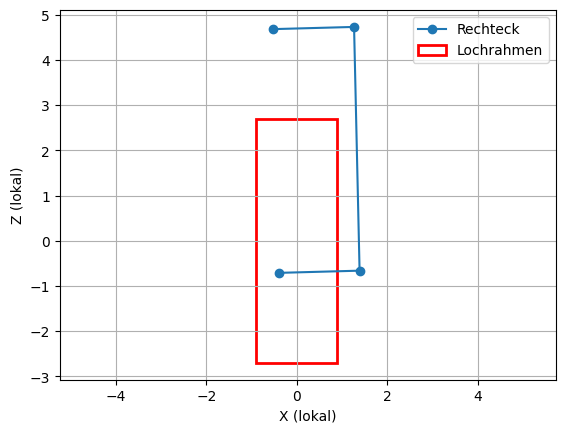

In [ ]:
rectangles_optim_hooks_local_1 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_1)
rectangles_optim_hooks_local_2 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_2)
rectangles_optim_hooks_local_3 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_3)
rectangles_optim_hooks_local_4 = transform_hook_rectangles_to_local(rectangles_optim_hooks, trajectory_4)

In [205]:
def check_hook_rectangles_in_hole_local(measurements, rectangles_hooks_local, hole_width, hole_height):
    """
    Prüft, ob alle Hakenrechtecke im LOCAL-Frame vollständig innerhalb der Lochfläche liegen.
    
    :param measurements: Dict mit lokalen Abweichungen (für Längenvergleich)
    :param rectangles_hooks_local: Liste von Rechtecken im LOCAL-Frame (4 Punkte je Rechteck)
    :param hole_width: Lochbreite (X-Richtung)
    :param hole_height: Lochhöhe (Z-Richtung)
    :return: (bool: passt durch, list: kollidierende Indizes)
    """
    max_x = hole_width / 2
    max_z = hole_height / 2

    collisions = []

    for i, rect in enumerate(rectangles_hooks_local):
        rect = np.array(rect)

        # Prüfe, ob alle 4 Punkte innerhalb [-w/2, +w/2] × [-h/2, +h/2] liegen (X/Z)
        within_x = np.abs(rect[:, 0]) < max_x
        within_z = np.abs(rect[:, 2]) < max_z
        if not np.all(within_x & within_z):
            collisions.append(i)

    fits = len(collisions) == 0
    return fits, collisions

In [206]:
fits_1, collisions_1 = check_hook_rectangles_in_hole_local(traj1_measurements, rectangles_optim_hooks_local_1, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits_1 else print(f"❌ Kollision an {len(collisions_1)} Stellen (Indizes):", collisions_1)

fits_2, collisions_2 = check_hook_rectangles_in_hole_local(traj2_measurements, rectangles_optim_hooks_local_2, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits_2 else print(f"❌ Kollision an {len(collisions_2)} Stellen (Indizes):", collisions_2)

fits_3, collisions_3 = check_hook_rectangles_in_hole_local(traj3_measurements, rectangles_optim_hooks_local_3, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits_3 else print(f"❌ Kollision an {len(collisions_3)} Stellen (Indizes):", collisions_3)

fits_4, collisions_4 = check_hook_rectangles_in_hole_local(traj4_measurements, rectangles_optim_hooks_local_4, hole_width, hole_height)
print("✅ Keine Kollision erkannt.") if fits_4 else print(f"❌ Kollision an {len(collisions_4)} Stellen (Indizes):", collisions_4)

❌ Kollision an 4 Stellen (Indizes): [74, 75, 76, 77]
✅ Keine Kollision erkannt.
✅ Keine Kollision erkannt.
✅ Keine Kollision erkannt.


***
### **3D-Plot der Trajektorie und Export als HTML**

In [207]:
def visualize_rectangles_html(rectangles, connect_points=None, 
                              secondary_rectangles=None, secondary_legend_title=None,
                              hook_rectangles = None,
                              hook_num=0, trajectory_process=1, html_filename="/home/mo/Thesis/Evaluation/Trajektorientests/CSV/plot_interaktiv.html",
                              collision_list = None, plot_collisions = False):
    """
    Visualisiert Rechtecke und Trajektorien im 3D-Raum als interaktive HTML-Datei.
        -> rectangles: Liste von Rechtecken (jeweils 4 Punkte [x, y, z])
        -> figsize: Größe der Plotfläche (Breite, Höhe)
        -> connect_points: Optionales Tupel mit zwei Punkten [x, y, z], die verbunden werden sollen
        -> secondary_rectangles: Optionaler zweiter Satz Rechtecke (werden grau dargestellt)
        -> secondary_legend_title: Optionaler Legenden-Eintrag für die grauen Rechtecke
        -> html_filename: Der Name der HTML-Datei, die erstellt wird
    """
    fig = go.Figure()

    ##### Berechnete Trajektorie (farbig)
    cmap = plt.cm.get_cmap('tab20')
    centers = []
    if rectangles:
        for i, rect in enumerate(rectangles):
            # Verwende rgba-String für die Farbe (anstatt des RGBA-Tupels)
            '''
            color = f"rgba({int(cmap(i / len(rectangles))[0] * 255)}, " \
                    f"{int(cmap(i / len(rectangles))[1] * 255)}, " \
                    f"{int(cmap(i / len(rectangles))[2] * 255)}, 1.0)"
            '''
            color = 'blue'
            x, y, z = zip(*rect)

            fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color=color, opacity=0.05, 
                                   name=f'P{i+1}'))
        
            center = np.mean(np.array(rect), axis=0)
            centers.append(center)

            text_label = ''
            # Füge den Text an den Punkten hinzu (mit entsprechender Position)
            fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                       mode='markers+text', marker=dict(size=3, color='blue'),
                                       text=text_label, textposition="top center", textfont=dict(size=12), showlegend=False))
            
            # Hinzufügen der Umrandung der Rechtecke mit einer Linie
            if i == 0 or i == (len(rectangles) - 1 ):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
                    fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                               mode='lines', 
                                               line=dict(color=color, width=4),  # Keine opacity hier
                                               showlegend=False))
        
        # Linie durch die berechneten Mittelpunkte
        centers = np.array(centers)
        fig.add_trace(go.Scatter3d(x=centers[:, 0], y=centers[:, 1], z=centers[:, 2],
                                   mode='lines', line=dict(color='black', width=2), name='Berechnete Hakenlinie'))

        # Beschriftung der ersten und letzten Punkte
        if len(centers) > 0:
            fig.add_trace(go.Scatter3d(x=[centers[0, 0]], y=[centers[0, 1]], z=[centers[0, 2]],
                                       mode='text', text=['Pre-Position'], textposition="top center", textfont=dict(size=10), showlegend=False))
        if len(centers) > 2:
            fig.add_trace(go.Scatter3d(x=[centers[-1, 0]], y=[centers[-1, 1]], z=[centers[-1, 2]],
                                       mode='text', text=['Loslassen'], textposition="top center", textfont=dict(size=10), showlegend=False))
        
        # Tunnelkanten: Ecken durchziehen mit denselben Farben wie bei den Rechtecken
        num_corners = 4  # Immer 4 Ecken pro Rechteck
        for corner_idx in range(num_corners):
            x_line, y_line, z_line = [], [], []
            colors = []
            for i, rect in enumerate(rectangles):
                # Farbcode für das Rechteck
                colors.append(f"rgba({int(cmap(i / len(rectangles))[0] * 255)}, " \
                        f"{int(cmap(i / len(rectangles))[1] * 255)}, " \
                        f"{int(cmap(i / len(rectangles))[2] * 255)}, 1.0)")
                            
                x, y, z = rect[corner_idx]
                x_line.append(x)
                y_line.append(y)
                z_line.append(z)
            
            # Die Tunnelkanten mit dem Farbcode der Rechtecke zeichnen
            fig.add_trace(go.Scatter3d(x=x_line, y=y_line, z=z_line,
                                       mode='lines',
                                       line=dict(color='blue', width=3),
                                       showlegend=False))


    ##### Optimal-Trajektorie (grün) – Zweite Rechtecke
    if secondary_rectangles:
        for i,rect in enumerate(secondary_rectangles):
            x, y, z = zip(*rect)
            fig.add_trace(go.Mesh3d(x=x, y=y, z=z, color='rgba(0,255,0,1.0)', opacity=0.05, 
                                   name=secondary_legend_title or 'Optimale Trajektorie'))
            
            # Hinzufügen der Umrandung der Rechtecke mit einer Linie
            if i == 0 or i == (len(secondary_rectangles) - 1):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]  # Nächster Punkt im Rechteck
                    fig.add_trace(go.Scatter3d(x=[x0, x1], y=[y0, y1], z=[z0, z1], 
                                               mode='lines', 
                                               line=dict(color='rgba(0,255,0,1.0)', width=3),  # Keine opacity hier
                                               showlegend=False))
            
            # Hinzufügen eines roten Punktes in der Mitte des Rechtecks
            center = np.mean(np.array(rect), axis=0)
            fig.add_trace(go.Scatter3d(x=[center[0]], y=[center[1]], z=[center[2]], 
                                       mode='markers', marker=dict(size=2, color='green'), 
                                       showlegend=False))
        
        # Mittelpunkte der sekundären Rechtecke sammeln
        secondary_centers = [np.mean(np.array(rect), axis=0) for rect in secondary_rectangles]
        secondary_centers = np.array(secondary_centers)

        # Linie durch die Mittelpunkte zeichnen
        fig.add_trace(go.Scatter3d(
            x=secondary_centers[:, 0], y=secondary_centers[:, 1], z=secondary_centers[:, 2],
            mode='lines',
            line=dict(color='rgba(0,255,0,1.0)', width=2),
            name='Optimale Hakenlinie'
        ))

        # Tunnelkanten Optimal-Trajektorie
        num_corners = 4  # Immer 4 Ecken pro Rechteck
        for corner_idx in range(num_corners):
            x_line, y_line, z_line = [], [], []
            colors = []
            for i, rect in enumerate(secondary_rectangles):                       
                x, y, z = rect[corner_idx]
                x_line.append(x)
                y_line.append(y)
                z_line.append(z)

            # Die Tunnelkanten mit dem Farbcode der Rechtecke zeichnen
            fig.add_trace(go.Scatter3d(x=x_line, y=y_line, z=z_line,
                                       mode='lines',
                                       line=dict(color='rgba(0,255,0,1.0)', width=3),
                                       showlegend=False))


    ##### Modellierte Hakenlinie
    if hook_rectangles:
        for i, rect in enumerate(hook_rectangles):
            x, y, z = zip(*rect)
            show_legend = i == 0  # Nur beim ersten Eintrag die Legende zeigen
            fig.add_trace(go.Mesh3d(
                x=x, y=y, z=z,
                color='rgba(0,0,0,1.0)',
                opacity=1.0,
                name='Haken (modelliert)',
                showlegend=show_legend
            ))
            
            # Umrandungslinien (optional showlegend=False hier)
            if i == 0 or i == (len(hook_rectangles) - 1):
                for j in range(4):
                    x0, y0, z0 = rect[j]
                    x1, y1, z1 = rect[(j + 1) % 4]
                    fig.add_trace(go.Scatter3d(
                        x=[x0, x1], y=[y0, y1], z=[z0, z1],
                        mode='lines', line=dict(color='rgba(0,0,0,1.0)', width=3), showlegend=False
                    ))
            
            # Mittelpunkt der "Spitze" (letztes Rechteck) als Punkt markieren
            if i == len(hook_rectangles) - 1:
                mx = sum(p[0] for p in rect) / 4
                my = sum(p[1] for p in rect) / 4
                mz = sum(p[2] for p in rect) / 4
    
                fig.add_trace(go.Scatter3d(
                    x=[mx], y=[my], z=[mz],
                    mode='markers', marker=dict(size=8, color='cyan'), name='Senke (modelliert)'
                ))
                fig.add_trace(go.Scatter3d(
                    x=[mx], y=[my], z=[mz],
                    mode='text', text=['Senke (modelliert)'], textposition="top center", textfont=dict(size=10), showlegend=False)
                )


    ##### Spitze und Senke (berechnet) in magenta inkl. graue Verbindungslinie
    if connect_points:
        p1, p2 = np.array(connect_points[0]), np.array(connect_points[1])
        fig.add_trace(go.Scatter3d(x=[p1[0], p2[0]], y=[p1[1], p2[1]], z=[p1[2], p2[2]], 
                                   mode='lines', line=dict(color='gray', dash='dash'), name='Direkte Gerade Spitze -> Senke'))
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Spitze (berechnet)'))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='markers', 
                                   marker=dict(size=8, color='magenta'), name='Senke (berechnet)'))
        
        # Hinzufügen von Text "Spitze" und "Senke"
        fig.add_trace(go.Scatter3d(x=[p1[0]], y=[p1[1]], z=[p1[2]], mode='text', 
                                   text=['Spitze (berechnet)'], textposition="top center", textfont=dict(size=10), showlegend=False))
        fig.add_trace(go.Scatter3d(x=[p2[0]], y=[p2[1]], z=[p2[2]], mode='text', 
                                   text=['Senke (berechnet)'], textposition="top center", textfont=dict(size=10), showlegend=False))
        

    ##### Kollisionen in rot
    if plot_collisions == True and collision_list is not None:
        first_i_for_legend = None
        for i, rect in enumerate(hook_rectangles):      # wenn Index in den Kollisionen enthalten -> rot einzeichnen
            if i in collision_list:
                x, y, z = zip(*rect)
                if first_i_for_legend is None:
                    first_i_for_legend = True      # Legendeeintrag nur für ersten Index zeigen
                
                fig.add_trace(go.Mesh3d(
                    x=x, y=y, z=z,
                    color='red',
                    opacity=1.0,
                    name='Kollision',
                    showlegend=first_i_for_legend
                ))
                first_i_for_legend = False
                
                # Umrandungslinien (optional showlegend=False hier)
                if i == 0 or i == (len(hook_rectangles) - 1):
                    for j in range(4):
                        x0, y0, z0 = rect[j]
                        x1, y1, z1 = rect[(j + 1) % 4]
                        fig.add_trace(go.Scatter3d(
                            x=[x0, x1], y=[y0, y1], z=[z0, z1],
                            mode='lines',
                            line=dict(color='red', width=3),
                            showlegend=False  # keine doppelten Legenden für Linien
                        ))
        

    # Achsen und Layout
    fig.update_layout(
        scene=dict(
            xaxis_title='X',
            yaxis_title='Y',
            zaxis_title='Z',
            aspectmode='cube',      # data
            camera=dict(
                up=dict(x=0, y=-1., z=0),
                eye=dict(x=-0.3, y=-0.3, z=-2)
            )),
        title=f'Haken {hook_num}, Trajektorien-Ansatz {trajectory_process}',
        legend=dict(title="Legende"))
    

    # HTML exportieren
    fig.write_html(html_filename)
    print(f"HTML-Datei '{html_filename}' erfolgreich erstellt!")
    # fig.show()

In [208]:
visualize_rectangles_html(
    rectangles = rectangles_1,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 1,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj1_frame_' + str(frame) + '.html',
    collision_list = collisions_1, plot_collisions = True,
    )

visualize_rectangles_html(
    rectangles = rectangles_2,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 2,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj2_frame_' + str(frame) + '.html',
    collision_list = collisions_2, plot_collisions = True,
    )

visualize_rectangles_html(
    rectangles = rectangles_3,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 3,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj3_frame_' + str(frame) + '.html',
    collision_list = collisions_3, plot_collisions = True,
    )

visualize_rectangles_html(
    rectangles = rectangles_4,
    secondary_rectangles = rectangles_optim,
    secondary_legend_title = 'optimale Trajektorie',
    hook_rectangles = rectangles_optim_hooks,
    connect_points = (trajectory_1[1][0], trajectory_1[-1][0]),
    hook_num = hook_num,
    trajectory_process = 4,
    html_filename = '/home/mo/Thesis/Evaluation/Trajektorientests/traj4_frame_' + str(frame) + '.html',
    collision_list = collisions_4, plot_collisions = True,
    )

/tmp/ipykernel_347894/207368947.py:18: MatplotlibDeprecationWarning:

The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.



HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj1_frame_.html' erfolgreich erstellt!
HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj2_frame_.html' erfolgreich erstellt!
HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj3_frame_.html' erfolgreich erstellt!
HTML-Datei '/home/mo/Thesis/Evaluation/Trajektorientests/traj4_frame_.html' erfolgreich erstellt!


***
***
### **CSV-Import und Aufbau einer vollständigen Tabelle**

In [209]:
import pandas as pd
import os
import re

def combine_measurement_csvs(folder_path, output_filename='combined_measurements.csv'):
    all_data = []

    # Alle CSV-Dateien im Ordner durchgehen
    for file in os.listdir(folder_path):
        if file.endswith('.csv'):
            filepath = os.path.join(folder_path, file)
            df = pd.read_csv(filepath)

            # Falls Spalten fehlen, über Dateiname extrahieren
            if 'hook_num' not in df.columns or 'trajectory_process' not in df.columns:
                match = re.search(r"hook(\d+)_traj(\d+)", file)
                if match:
                    hook_num = int(match.group(1))
                    trajectory_process = int(match.group(2))
                    df['hook_num'] = hook_num
                    df['trajectory_process'] = trajectory_process
            all_data.append(df)

    if all_data:
        combined_df = pd.concat(all_data, ignore_index=True)

        # Gruppieren und aggregieren
        aggregated_df = combined_df.groupby(['hook_num', 'trajectory_process'], as_index=False).agg({
            'x_max_local': 'max',
            'y_max_local': 'max',
            'z_max_local': 'max',
            'roll_max': 'max',
            'pitch_max': 'max',
            'yaw_max': 'max',
            'x_mean_local': 'mean',
            'y_mean_local': 'mean',
            'z_mean_local': 'mean'
        })

        # Spaltenreihenfolge setzen
        desired_columns = [
            'hook_num',
            'trajectory_process',
            'x_max_local',
            'y_max_local',
            'z_max_local',
            'roll_max',
            'pitch_max',
            'yaw_max',
            'x_mean_local',
            'y_mean_local',
            'z_mean_local'
        ]

        aggregated_df = aggregated_df[desired_columns]

        # CSV speichern
        combined_path = os.path.join(folder_path, output_filename)
        aggregated_df.to_csv(combined_path, index=False)
        print(f"Zusammengeführte Datei gespeichert unter: {combined_path}")
    else:
        print("Keine gültigen CSV-Dateien gefunden.")

In [210]:
combine_measurement_csvs('/home/mo/Thesis/Evaluation/Trajektorientests/CSV-Exporte/Frame_' + str(frame))

Zusammengeführte Datei gespeichert unter: /home/mo/Thesis/Evaluation/Trajektorientests/CSV-Exporte/Frame_/combined_measurements.csv
